In [1]:
#coding: utf-8
import numpy as np
import math 
import pandas as pd 

import matplotlib.pyplot as plt
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D

In [3]:
def radar_factory(num_vars, frame='circle'):
    """
    Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding axes.

    [1]【Python】Matplotlibで多角形のレーダーチャートを描く https://is.gd/l4VotP

    """
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarAxes(PolarAxes):

        name = 'radar'
        RESOLUTION = 1

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=0.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta


In [8]:
def elem_descripter(d, ax, color='r'):
    """
    Create a radar chart of element.

    Parameters
    ----------
    d : DataFrame
        Data on physical characteristics of elements.
    ax : pyplot.subplots
        Areas for plotting
    color : 'r'
        Color of radar chart.
    """
    labels = ['AW', 'group', 'period', 'atomic radius', 'electro\nnegativity', 'm. p.', 'b. p.','delta fus H\n(kJ/mol)', 'l (W/cm K)', 'Ionization\nenegy (eV)', 'Surface\nenergy', 'density']

    ax.plot(theta, d, color=color)
    ax.fill(theta, d, facecolor=color, alpha=0.2)
    ax.text(x=0, y=0.0, s=elem, ha='center', va='center', size=40)
    ax.tick_params(pad=13.0)
    ax.set_rgrids([0.2, 0.4, 0.6, 0.8], labels=[])
    ax.set_varlabels(labels)

In [6]:
descripters = pd.read_csv("data/Descriptors_20171121ver2.csv")
DPI = 100
des_all = ['AW', 'group', 'period', 'atomic radius', 'electronegativity', 'm. p.', 'b. p.','deltafus H (kJ/mol)', 'l (W/cm K)', 'Ionization enegy (eV)', 'Surface energy', 'density']

select = descripters[des_all]
select.index = descripters['symbol']
select.fillna(select.mean(), inplace=True)
table = (select - select.min())/(select.max() - select.min())

In [9]:
theta = radar_factory(12, frame='polygon')
elements = descripters['symbol'].to_list()

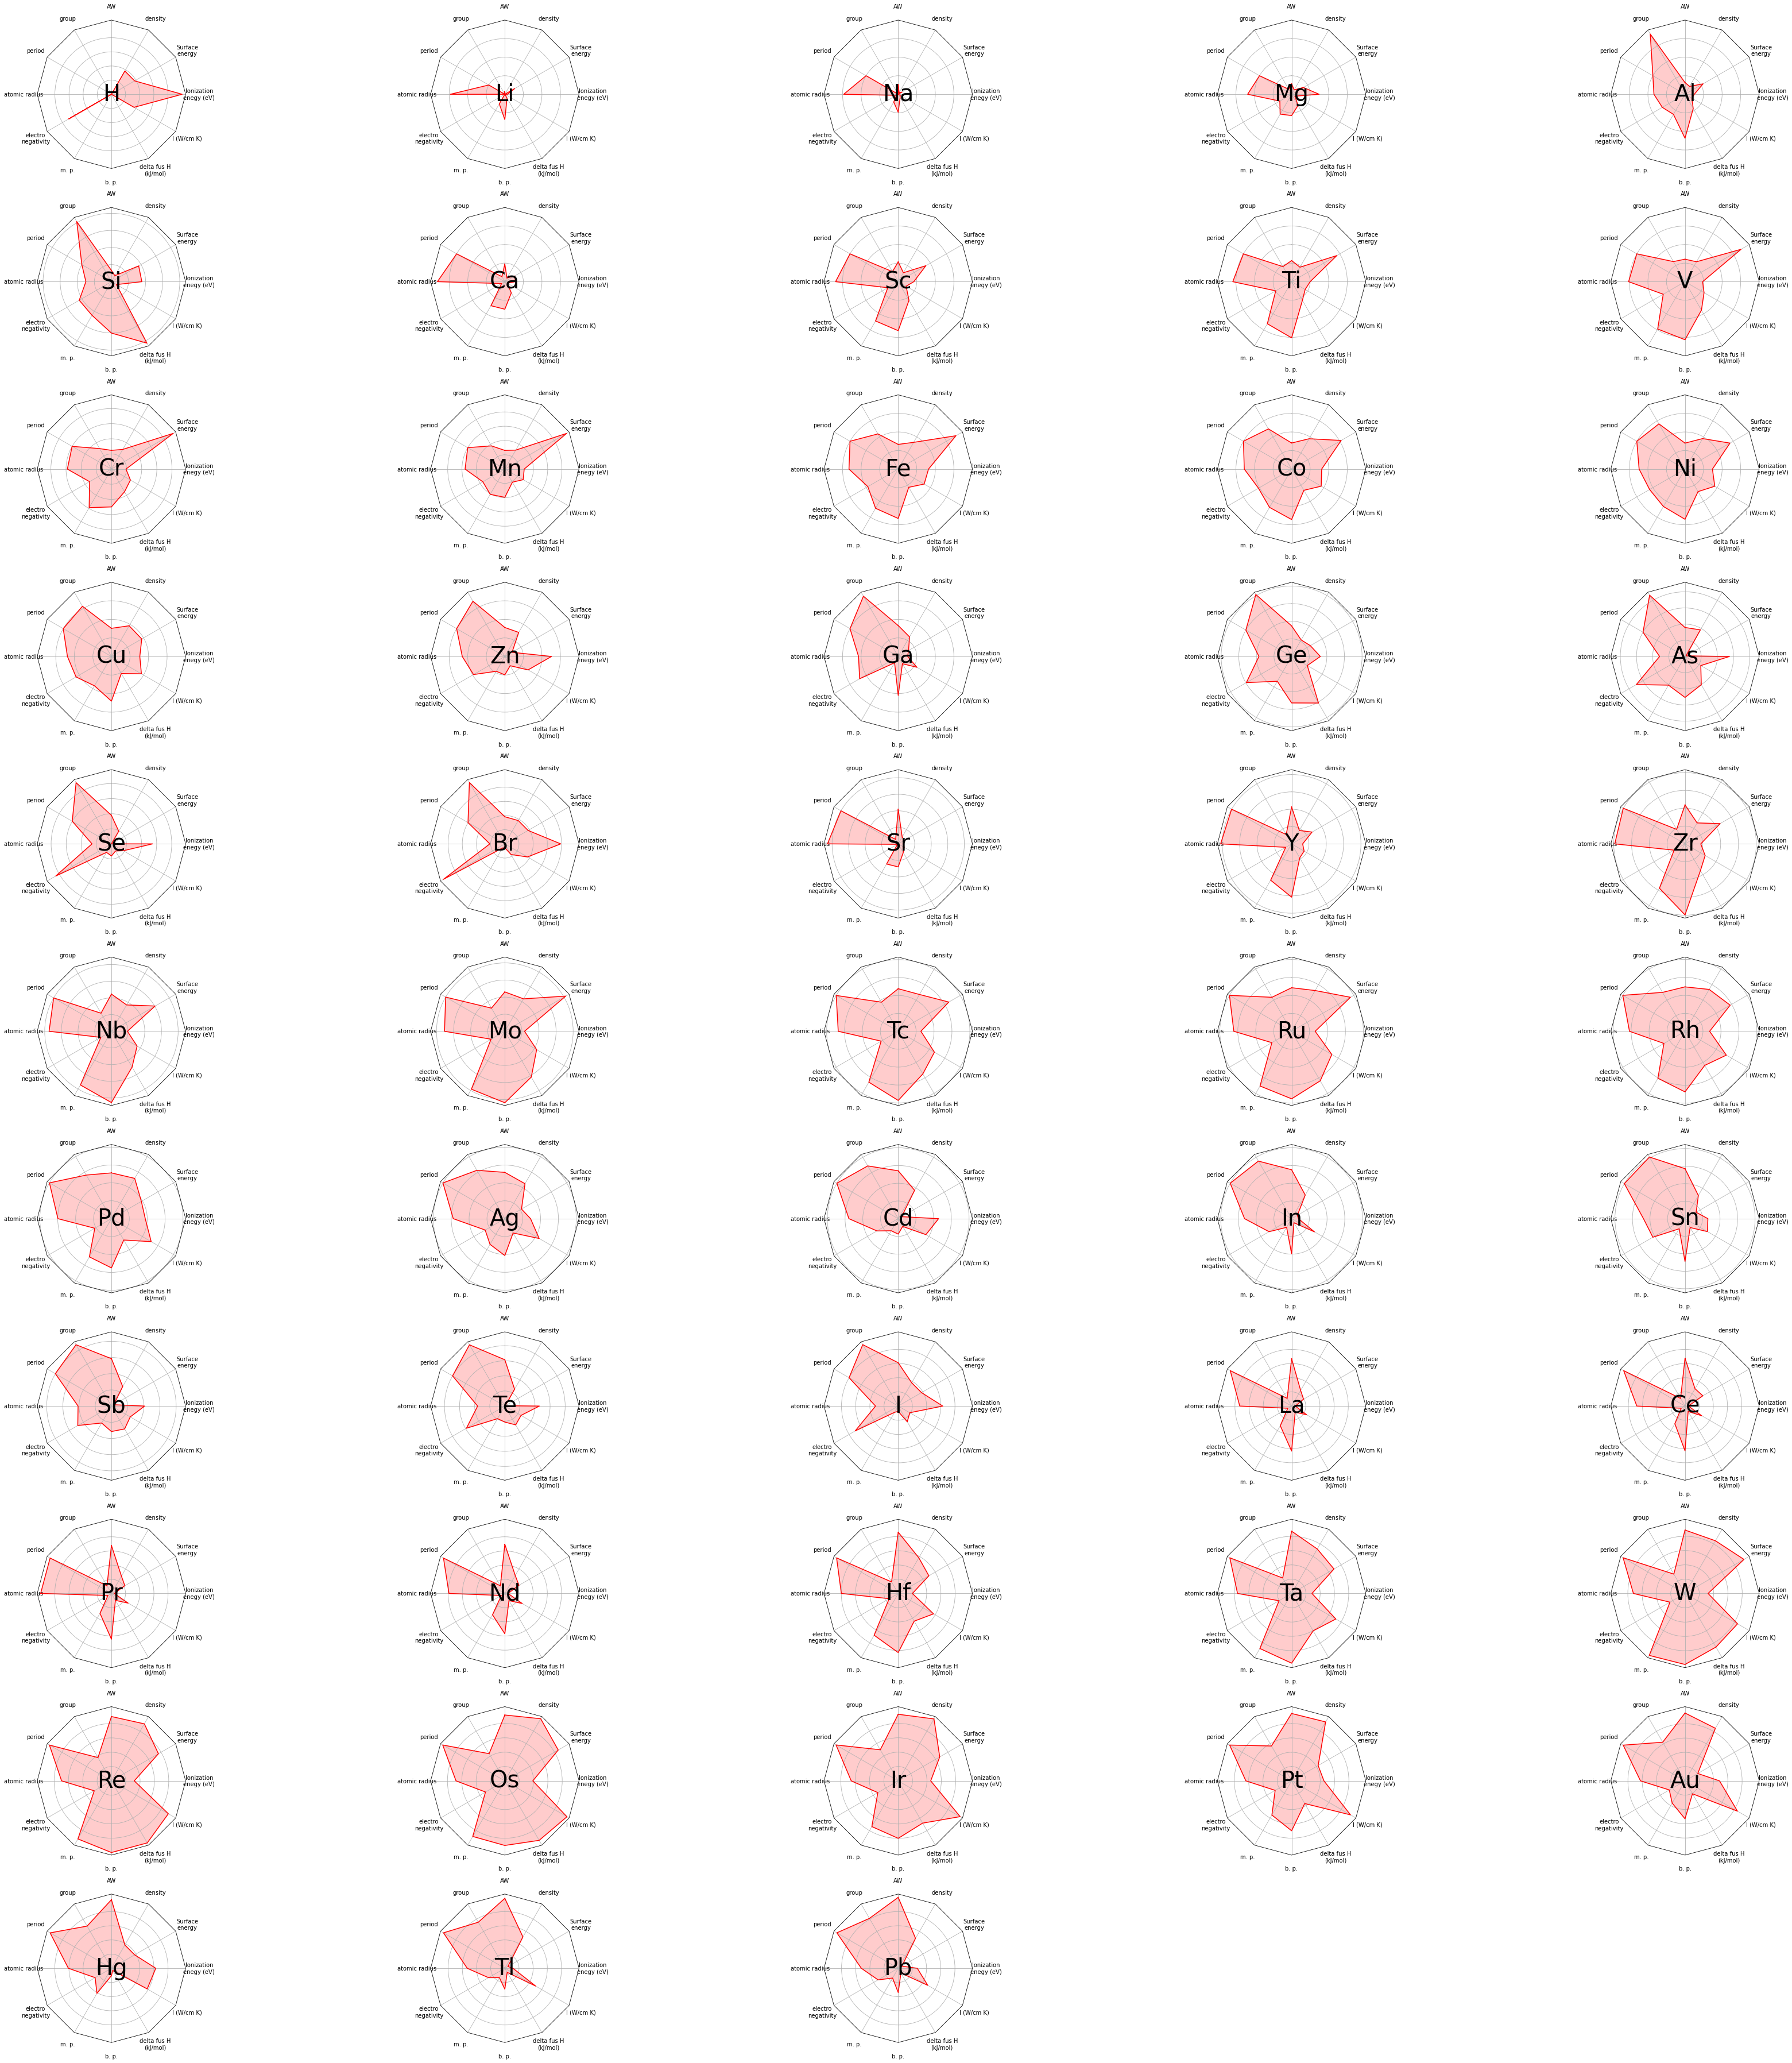

In [10]:
n_col = 5
n = math.ceil(len(elements)/n_col)
fig, ax = plt.subplots(n, n_col, figsize=(50, 50), subplot_kw=dict(projection='radar'))
#plt.subplots_adjust(wspace=0.4, hspace=2.0)
for i in range(n):
    for subset in [elements[n_col * i:n_col * i + n_col]]:
        for elem, a in zip(subset, ax[i]):
            elem_descripter(table.loc[elem, :], a, color='r')
        for j in range(n_col - len(subset)):
            ax[i][-(j+1)].set_axis_off()
        
fig.tight_layout()
plt.savefig('out/radar_chart.svg', dpi =DPI, bbox_inches = 'tight')